In [1]:
%matplotlib inline

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
import statistics as s
from collections import Counter, deque
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

class FinalSelection(State):
    
    def __init__(self, state):
        self.state = state
    
    @property
    def log(self):
        return []
    
    @property
    def dot(self):
        result = ["digraph G {", '  rankdir="RL";', ""]
        actions = Counter()

        stack = deque([self.state])
        visited = {id(self.state)}
        while stack:
            current = stack.popleft()
            current.final_selected = {
                work for work in current.related 
                if int(getattr(work, "final_selected", 0))
            }
            current.seed_set = {
                work for work in current.related 
                if int(getattr(work, "seed_set", 0))
            }
            current.delta_selected = {}
            current.delta_seed_set = {}
            options = [
                ("visited", len(current.visited)),
                ("WorkSnowball", len(current.related)),
                ("selected", len(current.final_selected)),
                ("seed_set", len(current.seed_set)),
            ]
            result.append('  {0} [label="{0}\\n{1}"];'.format(
                current.name, 
                "\\n".join("{}: {}".format(key, value) for key, value in options)
            ))
            if current.previous:
                operation = current.previous[1]
                for element in current.previous[0]:
                    if operation == "union":
                        result.append('  {} -> {} [label="{}"];'.format(
                            current.name, element.name, operation
                        ))
                        
                        
                    else:
                        current.delta_selected = {
                            work for work in current.delta_related 
                            if int(getattr(work, "final_selected", 0))
                        }
                        current.delta_seed_set = {
                            work for work in current.delta_related 
                            if int(getattr(work, "seed_set", 0))
                        }
                        
                        options = [
                            ("found", len(current.delta_visited)),
                            ("WorkSnowball", len(current.delta_related)),
                            ("selected", len(current.delta_selected)),
                            ("seed_set", len(current.delta_seed_set)),
                        ]
                        result.append('  {} -> {} [label="{}\\n{}"];'.format(
                            current.name, element.name, operation,
                            "\\n".join("{}: {}".format(key, value) for key, value in options)
                        ))
                    if id(element) not in visited:
                        stack.append(element)
                        visited.add(id(element))
            result.append("")

        result.append("}")
        return '\n'.join(result)


def precision_recall(state, total, final, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "fmeasure", 
        "final_precision", "final_recall", "final_fmeasure", 
        "operation", "delta_related", "delta_visited", "delta_selected",
        "related", "visited", "final_selected",
        "accumulated_precision", "accumulated_recall", "accumulated_fmeasure",
        "final_accumulated_precision", "final_accumulated_recall", "final_accumulated_fmeasure"
    ]]
    FinalSelection(state).dot
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        accumulated_recall = len(current.related) / len(total)
        recall = len(current.delta_related) / len(total)
        final_accumulated_recall = len(current.final_selected) / len(final)
        final_recall = len(current.delta_selected) / len(final)
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = float('nan')
        try:
            final_accumulated_precision = len(current.final_selected) / len(current.visited)
            final_precision = len(current.delta_selected) / len(current.delta_visited)
        except ZeroDivisionError:
            final_precision = float('nan')
        try:
            accumulated_fmeasure = s.harmonic_mean([accumulated_precision, accumulated_recall])
            fmeasure = s.harmonic_mean([precision, recall])
        except ZeroDivisionError:
            fmeasure = float('nan')
        try:
            final_accumulated_fmeasure = s.harmonic_mean([final_accumulated_precision, final_accumulated_recall])
            final_fmeasure = s.harmonic_mean([final_precision, final_recall])
        except ZeroDivisionError:
            final_fmeasure = float('nan')
            
            
        array.append([
            current.name,
            precision,
            recall,
            fmeasure,
            final_precision,
            final_recall,
            final_fmeasure,
            current.previous[1] if current.previous else "-",
            len(current.delta_related),
            len(current.delta_visited),
            len(current.delta_selected),
            len(current.related),
            len(current.visited),
            len(current.final_selected),
            accumulated_precision,
            accumulated_recall,
            accumulated_fmeasure,
            final_accumulated_precision,
            final_accumulated_recall,
            final_accumulated_fmeasure,
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array
#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários 22 do Seed Set + 29 Snowballing: ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))

Total de estudos primários 22 do Seed Set + 29 Snowballing:  51


In [4]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if x.category == "snowball"}
FINAL = {x for _, x in load_work_map_all_years() if getattr(x, "final_selected", 0)}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("ieee2015", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited

#strategy.initial.name
FinalSelection(state);

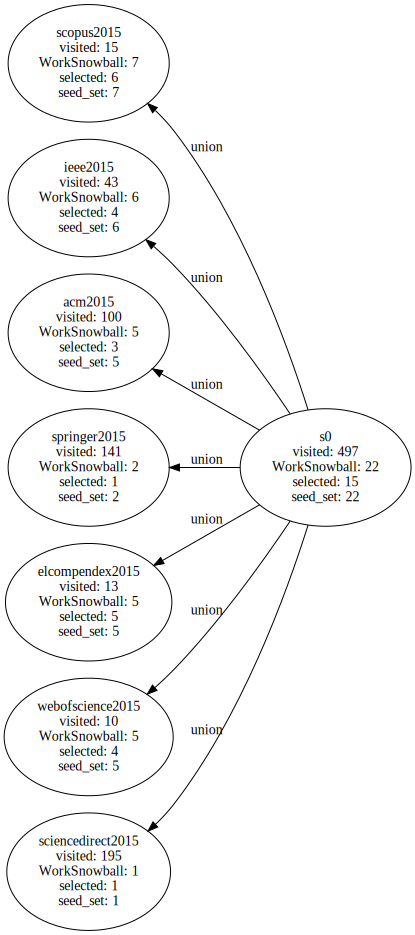

In [5]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus2015", "ieee2015", "acm2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015"], filter_function)
#strategy.initial.find("acm")
state = strategy.initial
FinalSelection(strategy.initial)

In [6]:
array = []
name = "E1"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

8,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,sciencedirect2015,0.00512821,0.0196078,0.00813008,0,0,0,-,1,195,0,1,195,1,0.00512821,0.0196078,0.00813008,0.00512821,0.0333333,0.00888889
1,webofscience2015,0.5,0.0980392,0.163934,0,0,0,-,5,10,0,5,10,4,0.5,0.0980392,0.163934,0.4,0.133333,0.2
2,elcompendex2015,0.384615,0.0980392,0.15625,0,0,0,-,5,13,0,5,13,5,0.384615,0.0980392,0.15625,0.384615,0.166667,0.232558
3,springer2015,0.0141844,0.0392157,0.0208333,0,0,0,-,2,141,0,2,141,1,0.0141844,0.0392157,0.0208333,0.0070922,0.0333333,0.0116959
4,acm2015,0.05,0.0980392,0.0662252,0,0,0,-,5,100,0,5,100,3,0.05,0.0980392,0.0662252,0.03,0.1,0.0461538
5,ieee2015,0.139535,0.117647,0.12766,0,0,0,-,6,43,0,6,43,4,0.139535,0.117647,0.12766,0.0930233,0.133333,0.109589
6,scopus2015,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
7,s0,NaN,0,0,NaN,0,0,union,0,0,0,22,497,15,0.0442656,0.431373,0.080292,0.0301811,0.5,0.056926


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

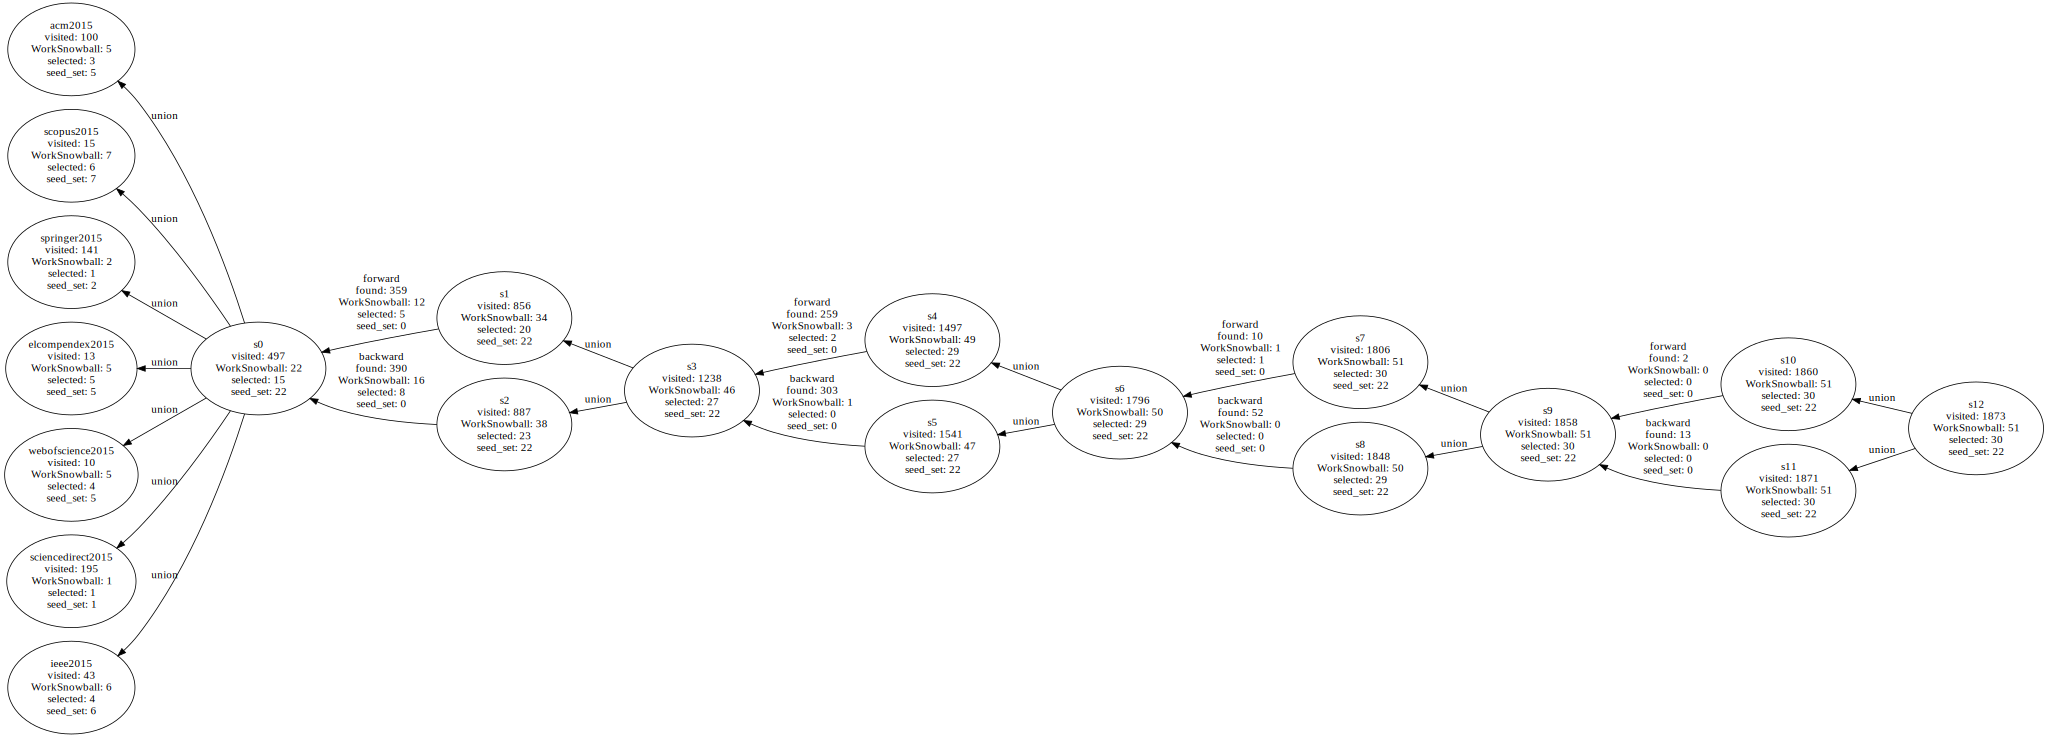

In [7]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm2015", "scopus2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015", "ieee2015"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

FinalSelection(state)

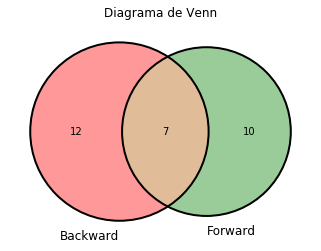

In [8]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [9]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['liu2005a', 'hinley1995a', 'mccoy1998a', 'murugappan2003a', 'basili2007a', 'messnarz1999a', 'lepmets2014a', 'basili2007b', 'mcloughlin2010a', 'münch2013c', 'liu2006a', 'kowalczyk2010a', 'armbrust2010a', 'basili2007c', 'debou2000a', 'trendowicz2011a', 'mandić2010d', 'münch2013a', 'martins2007b']
Forward ['münch2013c', 'kowalczyk2010a', 'armbrust2010a', 'münch2013a', 'unterkalmsteiner2014a', 'mcloughlin2010a', 'trendowicz2014a', 'armbrust2010b', 'trendowicz2011a', 'sun2010a', 'mandić2010d', 'cocozza2014a', 'stallinger2013a', 'birkhölzer2011a', 'trienekens2004a', 'mcloughlin2010b', 'karlström2002a']


In [10]:
name = "E2"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

20,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,ieee2015,0.139535,0.117647,0.12766,0,0,0,-,6,43,0,6,43,4,0.139535,0.117647,0.12766,0.0930233,0.133333,0.109589
1,sciencedirect2015,0.00512821,0.0196078,0.00813008,0,0,0,-,1,195,0,1,195,1,0.00512821,0.0196078,0.00813008,0.00512821,0.0333333,0.00888889
2,webofscience2015,0.5,0.0980392,0.163934,0,0,0,-,5,10,0,5,10,4,0.5,0.0980392,0.163934,0.4,0.133333,0.2
3,elcompendex2015,0.384615,0.0980392,0.15625,0,0,0,-,5,13,0,5,13,5,0.384615,0.0980392,0.15625,0.384615,0.166667,0.232558
4,springer2015,0.0141844,0.0392157,0.0208333,0,0,0,-,2,141,0,2,141,1,0.0141844,0.0392157,0.0208333,0.0070922,0.0333333,0.0116959
5,scopus2015,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
6,acm2015,0.05,0.0980392,0.0662252,0,0,0,-,5,100,0,5,100,3,0.05,0.0980392,0.0662252,0.03,0.1,0.0461538
7,s0,NaN,0,0,NaN,0,0,union,0,0,0,22,497,15,0.0442656,0.431373,0.080292,0.0301811,0.5,0.056926
8,s2,0.0410256,0.313725,0.0725624,0.0205128,0.266667,0.0380952,backward,16,390,8,38,887,23,0.042841,0.745098,0.0810235,0.0259301,0.766667,0.0501636
9,s1,0.0334262,0.235294,0.0585366,0.0139276,0.166667,0.0257069,forward,12,359,5,34,856,20,0.0397196,0.666667,0.0749724,0.0233645,0.666667,0.0451467


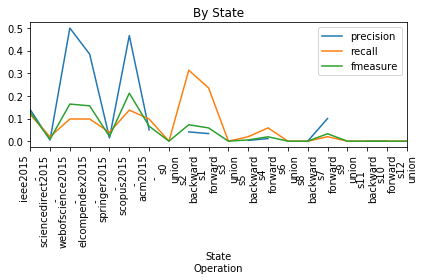

In [11]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
df['fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

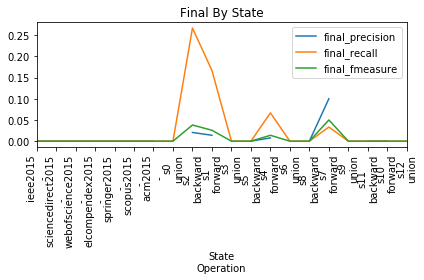

In [12]:
fig = plt.figure()
df['final_precision'].plot(legend=True)
df['final_recall'].plot(legend=True)
df['final_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Final By State");
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
plt.tight_layout()

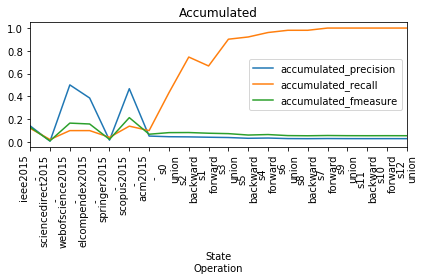

In [13]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
df['accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Accumulated");
plt.tight_layout()

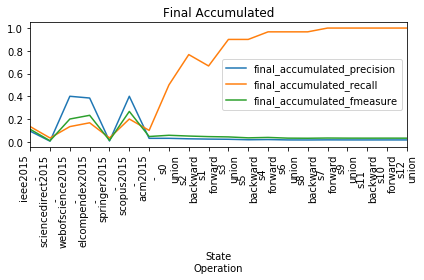

In [14]:
fig = plt.figure()
df['final_accumulated_precision'].plot(legend=True)
df['final_accumulated_recall'].plot(legend=True)
df['final_accumulated_fmeasure'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
plt.xticks(np.arange(0, len(df), 1.0), rotation='vertical')
plt.xlabel("State\nOperation")
ax.set_title("Final Accumulated");
plt.tight_layout()

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

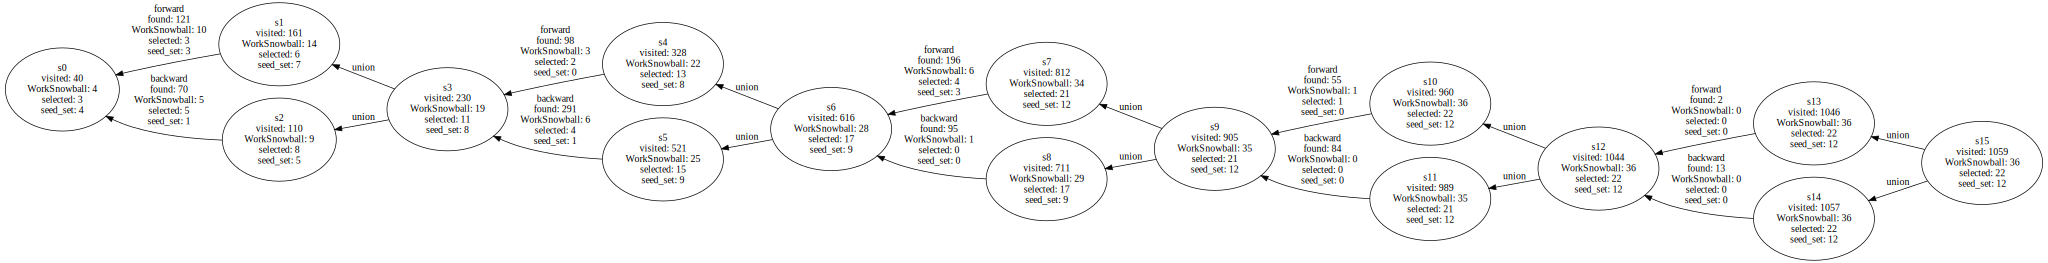

In [15]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
FinalSelection(state)

In [16]:
name = "E3"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

16,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.1,0.0784314,0.0879121,0,0,0,-,4,40,0,4,40,3,0.1,0.0784314,0.0879121,0.075,0.1,0.0857143
1,s2,0.0714286,0.0980392,0.0826446,0.0714286,0.166667,0.1,backward,5,70,5,9,110,8,0.0818182,0.176471,0.111801,0.0727273,0.266667,0.114286
2,s1,0.0826446,0.196078,0.116279,0.0247934,0.1,0.0397351,forward,10,121,3,14,161,6,0.0869565,0.27451,0.132075,0.0372671,0.2,0.0628272
3,s3,NaN,0,0,NaN,0,0,union,0,0,0,19,230,11,0.0826087,0.372549,0.135231,0.0478261,0.366667,0.0846154
4,s5,0.0206186,0.117647,0.0350877,0.0137457,0.133333,0.0249221,backward,6,291,4,25,521,15,0.0479846,0.490196,0.0874126,0.0287908,0.5,0.0544465
5,s4,0.0306122,0.0588235,0.0402685,0.0204082,0.0666667,0.03125,forward,3,98,2,22,328,13,0.0670732,0.431373,0.116095,0.0396341,0.433333,0.0726257
6,s6,NaN,0,0,NaN,0,0,union,0,0,0,28,616,17,0.0454545,0.54902,0.083958,0.0275974,0.566667,0.0526316
7,s8,0.0105263,0.0196078,0.0136986,0,0,0,backward,1,95,0,29,711,17,0.0407876,0.568627,0.0761155,0.02391,0.566667,0.0458839
8,s7,0.0306122,0.117647,0.048583,0.0204082,0.133333,0.0353982,forward,6,196,4,34,812,21,0.0418719,0.666667,0.0787949,0.0258621,0.7,0.0498812
9,s9,NaN,0,0,NaN,0,0,union,0,0,0,35,905,21,0.038674,0.686275,0.0732218,0.0232044,0.7,0.0449198



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

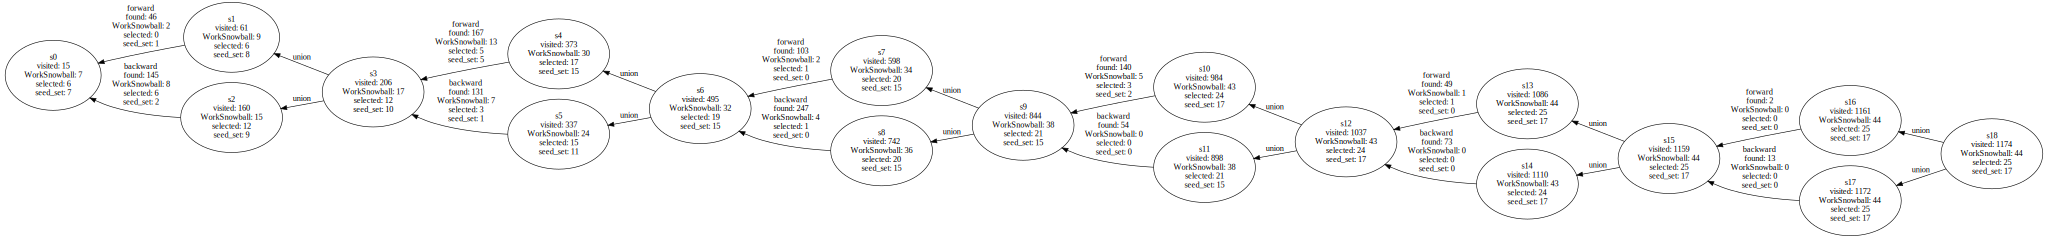

In [17]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
FinalSelection(state)

In [18]:
name = "E4"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

19,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
1,s2,0.0551724,0.156863,0.0816327,0.0413793,0.2,0.0685714,backward,8,145,6,15,160,12,0.09375,0.294118,0.14218,0.075,0.4,0.126316
2,s1,0.0434783,0.0392157,0.0412371,0,0,0,forward,2,46,0,9,61,6,0.147541,0.176471,0.160714,0.0983607,0.2,0.131868
3,s3,NaN,0,0,NaN,0,0,union,0,0,0,17,206,12,0.0825243,0.333333,0.132296,0.0582524,0.4,0.101695
4,s5,0.0534351,0.137255,0.0769231,0.0229008,0.1,0.0372671,backward,7,131,3,24,337,15,0.0712166,0.470588,0.123711,0.0445104,0.5,0.0817439
5,s4,0.0778443,0.254902,0.119266,0.0299401,0.166667,0.0507614,forward,13,167,5,30,373,17,0.080429,0.588235,0.141509,0.0455764,0.566667,0.0843672
6,s6,NaN,0,0,NaN,0,0,union,0,0,0,32,495,19,0.0646465,0.627451,0.117216,0.0383838,0.633333,0.072381
7,s8,0.0161943,0.0784314,0.0268456,0.00404858,0.0333333,0.00722022,backward,4,247,1,36,742,20,0.0485175,0.705882,0.0907945,0.0269542,0.666667,0.0518135
8,s7,0.0194175,0.0392157,0.025974,0.00970874,0.0333333,0.0150376,forward,2,103,1,34,598,20,0.0568562,0.666667,0.104777,0.0334448,0.666667,0.0636943
9,s9,NaN,0,0,NaN,0,0,union,0,0,0,38,844,21,0.0450237,0.745098,0.0849162,0.0248815,0.7,0.0480549


## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

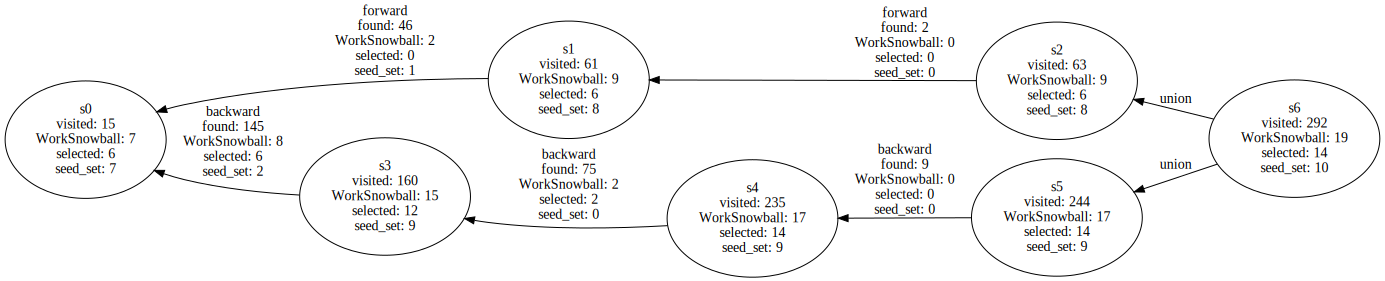

In [19]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.s2bbff2u()
FinalSelection(state)

In [20]:
name = "E5"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

7,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s3,0.0551724,0.156863,0.0816327,0.0413793,0.2,0.0685714,backward,8,145,6,15,160,12,0.09375,0.294118,0.14218,0.075,0.4,0.126316
1,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
2,s4,0.0266667,0.0392157,0.031746,0.0266667,0.0666667,0.0380952,backward,2,75,2,17,235,14,0.0723404,0.333333,0.118881,0.0595745,0.466667,0.10566
3,s1,0.0434783,0.0392157,0.0412371,0,0,0,forward,2,46,0,9,61,6,0.147541,0.176471,0.160714,0.0983607,0.2,0.131868
4,s5,0,0,0,0,0,0,backward,0,9,0,17,244,14,0.0696721,0.333333,0.115254,0.057377,0.466667,0.10219
5,s2,0,0,0,0,0,0,forward,0,2,0,9,63,6,0.142857,0.176471,0.157895,0.0952381,0.2,0.129032
6,s6,NaN,0,0,NaN,0,0,union,0,0,0,19,292,14,0.0650685,0.372549,0.110787,0.0479452,0.466667,0.0869565


## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

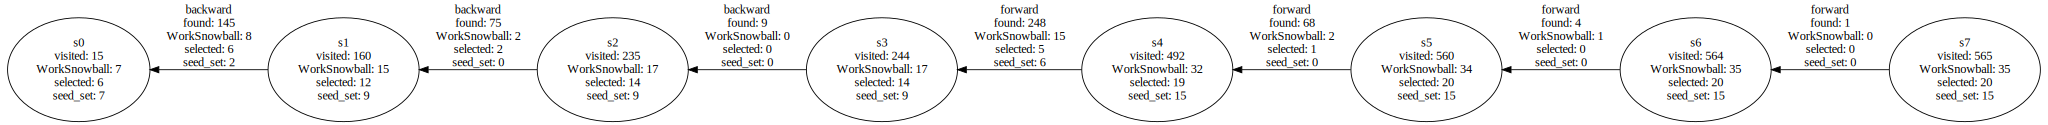

In [21]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.bbff()
FinalSelection(state)

In [22]:
name = "E6"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

8,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
1,s1,0.0551724,0.156863,0.0816327,0.0413793,0.2,0.0685714,backward,8,145,6,15,160,12,0.09375,0.294118,0.14218,0.075,0.4,0.126316
2,s2,0.0266667,0.0392157,0.031746,0.0266667,0.0666667,0.0380952,backward,2,75,2,17,235,14,0.0723404,0.333333,0.118881,0.0595745,0.466667,0.10566
3,s3,0,0,0,0,0,0,backward,0,9,0,17,244,14,0.0696721,0.333333,0.115254,0.057377,0.466667,0.10219
4,s4,0.0604839,0.294118,0.100334,0.0201613,0.166667,0.0359712,forward,15,248,5,32,492,19,0.0650407,0.627451,0.117864,0.0386179,0.633333,0.0727969
5,s5,0.0294118,0.0392157,0.0336134,0.0147059,0.0333333,0.0204082,forward,2,68,1,34,560,20,0.0607143,0.666667,0.111293,0.0357143,0.666667,0.0677966
6,s6,0.25,0.0196078,0.0363636,0,0,0,forward,1,4,0,35,564,20,0.0620567,0.686275,0.113821,0.035461,0.666667,0.0673401
7,s7,0,0,0,0,0,0,forward,0,1,0,35,565,20,0.0619469,0.686275,0.113636,0.0353982,0.666667,0.0672269


## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

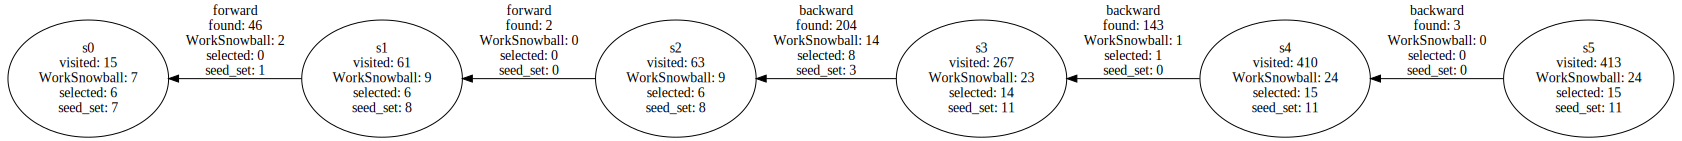

In [23]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus2015", filter_function=filter_function))
state = strategy.ffbb()
FinalSelection(state)

In [24]:
name = "E7"
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL, FINAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
last = df.iloc[-1].tolist()
strategy_row = [name] + last[11:]
array.append(strategy_row)
df

6,state,precision,recall,fmeasure,final_precision,final_recall,final_fmeasure,operation,delta_related,delta_visited,delta_selected,related,visited,final_selected,accumulated_precision,accumulated_recall,accumulated_fmeasure,final_accumulated_precision,final_accumulated_recall,final_accumulated_fmeasure
0,s0,0.466667,0.137255,0.212121,0,0,0,-,7,15,0,7,15,6,0.466667,0.137255,0.212121,0.4,0.2,0.266667
1,s1,0.0434783,0.0392157,0.0412371,0,0,0,forward,2,46,0,9,61,6,0.147541,0.176471,0.160714,0.0983607,0.2,0.131868
2,s2,0,0,0,0,0,0,forward,0,2,0,9,63,6,0.142857,0.176471,0.157895,0.0952381,0.2,0.129032
3,s3,0.0686275,0.27451,0.109804,0.0392157,0.266667,0.0683761,backward,14,204,8,23,267,14,0.0861423,0.45098,0.144654,0.0524345,0.466667,0.0942761
4,s4,0.00699301,0.0196078,0.0103093,0.00699301,0.0333333,0.0115607,backward,1,143,1,24,410,15,0.0585366,0.470588,0.104121,0.0365854,0.5,0.0681818
5,s5,0,0,0,0,0,0,backward,0,3,0,24,413,15,0.0581114,0.470588,0.103448,0.0363196,0.5,0.0677201


# Análise das Estratégias

In [25]:
%matplotlib inline
import pandas as pd

In [26]:
df = pd.DataFrame (array,columns = [
    'Estratégia', 'Related', 'Visited', 'Final Selected', 
    'Precision', 'Recall', 'F-Measure',
    'Final Precision', 'Final Recall', 'Final F-Measure'])
df.index = df['Estratégia']
df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,22,497,15,0.044266,0.431373,0.080292,0.030181,0.500000,0.056926
E2,E2,51,1873,30,0.027229,1.000000,0.053015,0.016017,1.000000,0.031529
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E4,E4,44,1174,25,0.037479,0.862745,0.071837,0.021295,0.833333,0.041528
E5,E5,19,292,14,0.065068,0.372549,0.110787,0.047945,0.466667,0.086957
E6,E6,35,565,20,0.061947,0.686275,0.113636,0.035398,0.666667,0.067227
E7,E7,24,413,15,0.058111,0.470588,0.103448,0.036320,0.500000,0.067720


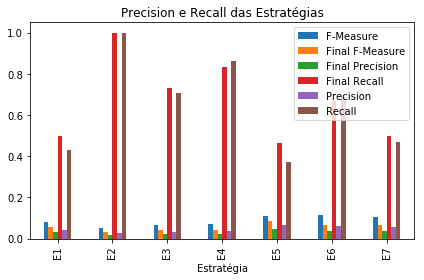

In [27]:
import matplotlib.pyplot as plt
exclude = ['Related', 'Visited', 'Final Selected']

ax = df.loc[:, df.columns.difference(exclude)].plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [28]:
df

,Estratégia,Related,Visited,Final Selected,Precision,Recall,F-Measure,Final Precision,Final Recall,Final F-Measure
Estratégia,,,,,,,,,,
E1,E1,22,497,15,0.044266,0.431373,0.080292,0.030181,0.500000,0.056926
E2,E2,51,1873,30,0.027229,1.000000,0.053015,0.016017,1.000000,0.031529
E3,E3,36,1059,22,0.033994,0.705882,0.064865,0.020774,0.733333,0.040404
E4,E4,44,1174,25,0.037479,0.862745,0.071837,0.021295,0.833333,0.041528
E5,E5,19,292,14,0.065068,0.372549,0.110787,0.047945,0.466667,0.086957
E6,E6,35,565,20,0.061947,0.686275,0.113636,0.035398,0.666667,0.067227
E7,E7,24,413,15,0.058111,0.470588,0.103448,0.036320,0.500000,0.067720


In [29]:
#df.to_csv("estrategias.csv")
df.to_excel("estrategias.xlsx")